In [1]:
#Adding directory so that we can import 'source' which is a package in this project
import sys
import os
path = os.getcwd().replace('/Project3','')
sys.path.append(path) 

In [2]:
from diffusers import StableDiffusionPipeline
import torch
from transformers import pipeline
from PIL import Image
import random
from source.utils import utils
import cv2
import matplotlib.pyplot as plt
import numpy as np

In the below cell, we setup the GPU, the stable diffuion model to generate images and the zero shot object detector to get the class and bounding box coordinates. We also fetch the list of class names to randomly select from to create images

In [3]:
mps_device = torch.device('mps')

gen_model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(gen_model_id, torch_dtype=torch.float16)
pipe.to(mps_device)

checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

class_list = []
with open('../classes.txt') as f:
    classes = f.readlines()
    for classname in classes:
        class_list.append(classname.strip('\n'))

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The following three cells are functions that will help in this process 

In [8]:
def create_image(id):
    """
    This function will use the Stable Diffusion model to create an image using a random class name as the prompt
    
    Arguments
    id (int): This will be used to label the created image

    Returns
    classnames (list): List of unique classes used in prompt to create image
    """
    #Select a random class name from all the possible classes
    classnames = random.sample(class_list,1)

    prompt = "".join(classnames)
    image = pipe(prompt).images[0]  

    print("Creating an image of a "+prompt)

    image.save(f"./synthetic/images/test{id}.JPEG")

    return classnames

In [9]:
def process_bbox_coordinates(image,box_coords):
    """
    To train on these images using the YOLO model we need to scale the x_center, y_center, width and height of the bounding box

    Argument:
    image (PIL): The image of interest

    Return:
    tuple consisting of scaled values in form (x_center, y_center, width, height)
    """

    img_width = image.size[0]
    img_height= image.size[1]
    
    x_center = int((box_coords['xmin'] + box_coords['xmax'])/2)
    y_center = int((box_coords['ymin'] + box_coords['ymax'])/2)
    height = int(box_coords['ymax'] - box_coords['ymin'])
    width = int(box_coords['xmax']- box_coords['xmin'])

    return (x_center/img_width, y_center/img_height, width/img_width, height/img_height)

    

In [12]:
def generate_bounding_boxes(id,classnames):
    """
    This will use the zero shot object detector to get the class and bounding box to create the label txt file of the image

    Arguments
    id (int): This will be used as the name of the label file corresponding to its image 
    classnames (list): This will be used to tell the object detector what we are looking for

    """
    try:
        image = Image.open(f"./synthetic/images/test{id}.JPEG") 
        predictions = detector(image, candidate_labels=classnames)# Object detector makes predictions knowing what it is looking for from classnames
        
        print("Prediction: {}".format(predictions[0]))
        
        key_predictions = sorted(predictions, key=lambda d: d['score'], reverse=True) # We want to get the prediction with the highest score
        
    # Here we create the label txt file and write the class index and the scaled values using the 'process_bbox_coordinates' function in one line
        with open(f'./synthetic/labels/test{id}.txt','w') as label:
            bbox_scaled = process_bbox_coordinates(image, key_predictions[0]['box'])
            label.writelines(f"{utils.get_class_index(key_predictions[0]['label'])} {bbox_scaled[0]} {bbox_scaled[1]} {bbox_scaled[2]} {bbox_scaled[3]}\n")
            
        print("Saving label file as ./synthetic/labels/test{}.txt".format(id))
    except:
        print('No annotations! Removing this image...')
        os.remove(f"./synthetic/images/test{id}.JPEG")

We can go ahead and create the images and their corresponding label txt files which are saved into the synthetic directory

In [13]:
quantity = 25 # Number of images to generate (each one takes about 40 seconds to create)

for i in range(quantity):
    classnames = create_image(i)
    generate_bounding_boxes(i,classnames)

  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a cabinet
Prediction: {'score': 0.6846950054168701, 'label': 'cabinet', 'box': {'xmin': 73, 'ymin': 116, 'xmax': 511, 'ymax': 470}}
Saving label file as ./synthetic/labels/test0.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a plate
Prediction: {'score': 0.4392102360725403, 'label': 'plate', 'box': {'xmin': 10, 'ymin': 5, 'xmax': 491, 'ymax': 488}}
Saving label file as ./synthetic/labels/test1.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a backpack
Prediction: {'score': 0.8656411170959473, 'label': 'backpack', 'box': {'xmin': 85, 'ymin': 38, 'xmax': 425, 'ymax': 496}}
Saving label file as ./synthetic/labels/test2.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a trophy
Prediction: {'score': 0.8426738977432251, 'label': 'trophy', 'box': {'xmin': 191, 'ymin': 0, 'xmax': 335, 'ymax': 394}}
Saving label file as ./synthetic/labels/test3.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a basket
Prediction: {'score': 0.7588320970535278, 'label': 'basket', 'box': {'xmin': 11, 'ymin': 11, 'xmax': 498, 'ymax': 512}}
Saving label file as ./synthetic/labels/test4.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a eraser
Prediction: {'score': 0.4392722249031067, 'label': 'eraser', 'box': {'xmin': 163, 'ymin': 203, 'xmax': 353, 'ymax': 295}}
Saving label file as ./synthetic/labels/test5.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a scissors
Prediction: {'score': 0.9084880352020264, 'label': 'scissors', 'box': {'xmin': 3, 'ymin': 52, 'xmax': 506, 'ymax': 417}}
Saving label file as ./synthetic/labels/test6.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a guitar
Prediction: {'score': 0.8748876452445984, 'label': 'guitar', 'box': {'xmin': 118, 'ymin': 2, 'xmax': 387, 'ymax': 507}}
Saving label file as ./synthetic/labels/test7.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a desk_lamp
Prediction: {'score': 0.6391646862030029, 'label': 'desk_lamp', 'box': {'xmin': 2, 'ymin': 27, 'xmax': 273, 'ymax': 480}}
Saving label file as ./synthetic/labels/test8.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a faucet
Prediction: {'score': 0.907518744468689, 'label': 'faucet', 'box': {'xmin': 98, 'ymin': 114, 'xmax': 459, 'ymax': 430}}
Saving label file as ./synthetic/labels/test9.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a faucet
Prediction: {'score': 0.8159260153770447, 'label': 'faucet', 'box': {'xmin': 145, 'ymin': 157, 'xmax': 294, 'ymax': 342}}
Saving label file as ./synthetic/labels/test10.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a tvmonitor
Prediction: {'score': 0.858711302280426, 'label': 'tvmonitor', 'box': {'xmin': 1, 'ymin': 29, 'xmax': 508, 'ymax': 484}}
Saving label file as ./synthetic/labels/test11.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a bicycle
Prediction: {'score': 0.7325811386108398, 'label': 'bicycle', 'box': {'xmin': 6, 'ymin': 122, 'xmax': 510, 'ymax': 424}}
Saving label file as ./synthetic/labels/test12.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Creating an image of a pencil
No annotations! Removing this image...


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a rifle
Prediction: {'score': 0.4477459490299225, 'label': 'rifle', 'box': {'xmin': 2, 'ymin': 103, 'xmax': 506, 'ymax': 481}}
Saving label file as ./synthetic/labels/test14.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a screwdriver
Prediction: {'score': 0.5280088186264038, 'label': 'screwdriver', 'box': {'xmin': 1, 'ymin': 200, 'xmax': 380, 'ymax': 376}}
Saving label file as ./synthetic/labels/test15.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a coffee_maker
Prediction: {'score': 0.657585620880127, 'label': 'coffee_maker', 'box': {'xmin': 0, 'ymin': 16, 'xmax': 135, 'ymax': 504}}
Saving label file as ./synthetic/labels/test16.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a laptop
Prediction: {'score': 0.8085358738899231, 'label': 'laptop', 'box': {'xmin': 48, 'ymin': 93, 'xmax': 473, 'ymax': 512}}
Saving label file as ./synthetic/labels/test17.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a watch
Prediction: {'score': 0.759554922580719, 'label': 'watch', 'box': {'xmin': 103, 'ymin': 52, 'xmax': 287, 'ymax': 491}}
Saving label file as ./synthetic/labels/test18.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a pan
No annotations! Removing this image...


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a remote_control
Prediction: {'score': 0.536748468875885, 'label': 'remote_control', 'box': {'xmin': 351, 'ymin': 147, 'xmax': 508, 'ymax': 459}}
Saving label file as ./synthetic/labels/test20.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a bucket
Prediction: {'score': 0.2476123720407486, 'label': 'bucket', 'box': {'xmin': 132, 'ymin': 256, 'xmax': 375, 'ymax': 510}}
Saving label file as ./synthetic/labels/test21.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a flashlight
Prediction: {'score': 0.22178420424461365, 'label': 'flashlight', 'box': {'xmin': 137, 'ymin': 66, 'xmax': 224, 'ymax': 444}}
Saving label file as ./synthetic/labels/test22.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a cellphone
Prediction: {'score': 0.7227771282196045, 'label': 'cellphone', 'box': {'xmin': 22, 'ymin': 161, 'xmax': 174, 'ymax': 369}}
Saving label file as ./synthetic/labels/test23.txt


  0%|          | 0/50 [00:00<?, ?it/s]

Creating an image of a fish_tank
Prediction: {'score': 0.6599017977714539, 'label': 'fish_tank', 'box': {'xmin': 3, 'ymin': 3, 'xmax': 507, 'ymax': 507}}
Saving label file as ./synthetic/labels/test24.txt


We can take an example of an image that was synthetically generated and its annotations created from the zero shot object detector to visualise the bounding box

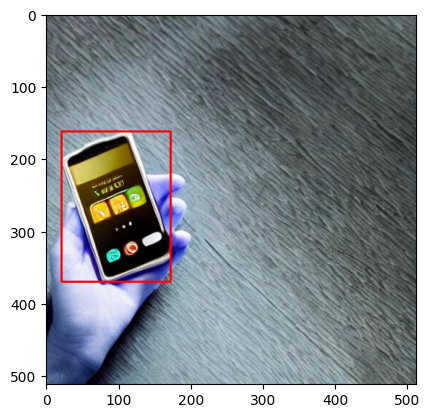

In [15]:
image = cv2.imread('./synthetic/images/test23.JPEG')

predictions = detector(Image.fromarray(image), candidate_labels=['cellphone'])
key_predictions = sorted(predictions, key=lambda d: d['score'], reverse=True)

#Drawing the box into the image
cv2.rectangle(image, (int(key_predictions[0]['box']['xmin']),int(key_predictions[0]['box']['ymin'])), (int(key_predictions[0]['box']['xmax']),int(key_predictions[0]['box']['ymax'])), color=(255, 0, 0), thickness=2)

plt.imshow(image)